In [27]:
import torch
import math
from matplotlib import pyplot as plt
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam


#VARIÁVEIS GLOBAIS DO NOTEBOOK

total_Amostras = 1000 # numero total de amostras do dataset
NOISE = 0.            # intensidade do ruido de coleta no dataset
SPLIT_RATIO = 0.5     # porcentagem de dados usados no dataset de treino
BATCH_SIZE = 10       # tamanho do batch usado durante o treinamento (batch: lotes menores do total de amostras)
LEARNING_RATE = 0.001 # taxa de aprendizado (diz respeito ao tamanho do passo dado na adaptação dos classificadores lineares)
EPOCHS = 250          # quantidade de Épocas

#AS CLASSES DE DATASETS SE INICIALIZAM UTILIZANDO AS FUNÇÕES GEN (SPIRAL, CIRCLE...)
#CONTUDO, TRIVIAL E FINALMENTE, NADA MAIS SÃO QUE UM CONJUNTO DE COORDENADAS E RÓTULOS PARA ESSAS COORDENADAS
#VAMOS PADRONIZAR QUE DATASETS GENÉRICOS JÁ SÃO INICIALIZADOS COM ARRAYS NUMPY

class GenericDataset:
    def __init__(self):
        self.coordenadas = np.empty(0)
        self.labels = np.empty(0)

#FUNÇÕES PÚBLICAS DO NOTEBOOK

def plotar(dataset):

    if(isinstance(dataset,GenericDataset)):
        coordenadas_numpy = dataset.coordenadas         #Datasets genéricos trabalham nativamente com numpy
        labels_numpy = dataset.labels                   #Não é necessária a conversão
    else:
        coordenadas_numpy = dataset.coordenadas.numpy() #Converte dataset.coordenadas de tensor para array numpy
        labels_numpy = dataset.labels.numpy()           #Converte dataset.labels de tensor para array numpy


    coordenadas_Positivas = coordenadas_numpy[labels_numpy == 1]  # Filtra os valores de coordenadas com o label 1 (positivas)
    coordenadas_Negativas = coordenadas_numpy[labels_numpy == -1] # Filtra os valores de coordenadas com o label -1 (negativas)

    plt.figure(figsize=(8,6)) # gera uma figura no tamanho sugerido


    # Configurações da figura:
    plt.scatter(coordenadas_Positivas[:, 0], coordenadas_Positivas[:, 1], color='blue', marker='o', label='Positive') #plota os pontos positivos azuis
    plt.scatter(coordenadas_Negativas[:, 0], coordenadas_Negativas[:, 1], color='red', marker='o', label='Negative')  #plota os pontos negativos vermelhos

    # Legendas do gráfico:
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    plt.show() #mostra o gráfico resultante

In [19]:
def genSpiral(delta_t, label):         #label é o rótulo das amostras, sua categoria (1 ou -1)
                                       #delta_t é um ângulo para a alternância dos braços espirais
    r = 5*torch.linspace(0., 1., total_Amostras//2+1)[:total_Amostras//2]
    t = 0.7*r*math.pi + delta_t
    x0 = r*torch.sin(t)
    x1 = r*torch.cos(t)
    labels = label*torch.ones_like(x0)
    coordenadas = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/70.)*(2*torch.rand(total_Amostras//2, 2) - 1.)
    coordenadas += sampled_noise
    return coordenadas, labels          #coordenadas é um conjunto de pares ordenados; labels é um conjunto de rótulos (1 ou -1)

class SpiralDataset:
    """
    Classe do dataset Espiral
    self.coordenadas são todas as coordenadas concatenadas (positivas e negativas)
    self.labels são todos os rótulos dessas coordenadas
    """
    def __init__(self):
        coordenadasPositivas, labelsPositivos = genSpiral(0, 1)          # positive samples: amostras com label 1
        coordenadasNegativas, labelsNegativos = genSpiral(math.pi, -1)   # negative samples: amostras com label -1
        self.coordenadas = torch.cat((coordenadasPositivas, coordenadasNegativas))  #concatena todas as coordenadas
        self.labels = torch.cat((labelsPositivos, labelsNegativos))                 #concatena todas os labels

"""
TESTE AS SEGUINTES LINHAS PARA VISUALIZAR
AS COORDENADAS E RÓTULOS DO DATASET ESPIRAL

espiral = SpiralDataset()
print(espiral.coordenadas)
print(espiral.labels)
"""

# TO DO: plotar dataset gerado

"""
TESTE AS SEGUINTES LINHAS PARA VISUALIZAR O GRÁFICO DO DATASET ESPIRAL

espiral = SpiralDataset()
plotar(espiral)
"""

'\nTESTE AS SEGUINTES LINHAS PARA VISUALIZAR O GRÁFICO DO DATASET ESPIRAL\n\nespiral = SpiralDataset()\nplotar(espiral)\n'

In [20]:
def genGauss(coordenada_x_central, coordenada_y_central, label): #label é o rótulo das amostras, sua categoria (1 ou -1)
                                                                 #coordenadas centrais indicam os centros das distribuições gaussianas
    coordenadas = 0.7*torch.randn(total_Amostras//2, 2)
    coordenadas = torch.tensor([coordenada_x_central, coordenada_y_central]) + coordenadas + coordenadas*(NOISE/25.)
    labels = label*torch.ones(total_Amostras//2)
    return coordenadas, labels   #coordenadas é um conjunto de pares ordenados; labels é um conjunto de rótulos (1 ou -1)

class GaussDataset:
    """
    Classe do dataset Gauss
    self.coordenadas são todas as coordenadas concatenadas (positivas e negativas)
    self.labels são todos os rótulos dessas coordenadas
    """
    def __init__(self):
        coordenadasPositivas, labelsPositivos = genGauss(2, 2, 1) #positive samples: amostras com label 1
        coordenadasNegativas, labelsNegativos = genGauss(-2, -2, -1) #negative samples: amostras com label -1
        self.coordenadas = torch.cat((coordenadasPositivas, coordenadasNegativas))  #concatena todas as coordenadas
        self.labels = torch.cat((labelsPositivos, labelsNegativos))                 #concatena todas os labels

"""
TESTE AS SEGUINTES LINHAS PARA VISUALIZAR
AS COORDENADAS E RÓTULOS DO DATASET GAUSS

gauss = GaussDataset()
print(gauss.coordenadas)
print(gauss.labels)
"""

# TO DO: plotar dataset gerado

"""
TESTE AS SEGUINTES LINHAS PARA VISUALIZAR O GRÁFICO DO DATASET GAUSS

gauss = GaussDataset()
plotar(gauss)
"""

'\nTESTE AS SEGUINTES LINHAS PARA VISUALIZAR O GRÁFICO DO DATASET GAUSS\n\ngauss = GaussDataset()\nplotar(gauss)\n'

In [21]:
def genCircle(r_min, r_max, label):   #label é o rótulo das amostras, sua categoria (1 ou -1)
                                      #os raios r_min e r_max indicam a distância dos dois círculos do centro do plano
    r = (r_max - r_min)*torch.rand(total_Amostras//2) + r_min
    angle = 2*math.pi*torch.rand(total_Amostras//2)
    x0 = r*torch.sin(angle)
    x1 = r*torch.cos(angle)
    coordenadas = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/35.)*(2*torch.rand(total_Amostras//2, 2) - 1.)
    coordenadas += sampled_noise
    labels = label*torch.ones_like(x0)
    return coordenadas, labels   #coordenadas é um conjunto de pares ordenados; labels é um conjunto de rótulos (1 ou -1)

class CircleDataset:
    """
    Classe do dataset Circle
    self.coordenadas são todas as coordenadas concatenadas (positivas e negativas)
    self.labels são todos os rótulos dessas coordenadas
    """
    def __init__(self):
        coordenadasPositivas, labelsPositivos = genCircle(0, 2.5, 1) #positive samples: amostras com label 1
        coordenadasNegativas, labelsNegativos = genCircle(3.5, 5, -1) #negative samples: amostras com label -1
        self.coordenadas = torch.cat((coordenadasPositivas, coordenadasNegativas))  #concatena todas as coordenadas
        self.labels = torch.cat((labelsPositivos, labelsNegativos))                 #concatena todas os labels

"""
TESTE AS SEGUINTES LINHAS PARA VISUALIZAR
AS COORDENADAS E RÓTULOS DO DATASET CIRCLE

circle = CircleDataset()
print(circle.coordenadas)
print(circle.labels)
"""

# TO DO: plotar dataset gerado

"""
TESTE AS SEGUINTES LINHAS PARA VISUALIZAR O GRÁFICO DO DATASET CIRCLE

circle = CircleDataset()
plotar(circle)
"""

'\nTESTE AS SEGUINTES LINHAS PARA VISUALIZAR O GRÁFICO DO DATASET CIRCLE\n\ncircle = CircleDataset()\nplotar(circle)\n'

In [22]:
def genXOR():
    coordenadas = 10.*torch.rand(total_Amostras, 2) - 5.
    labels = torch.sign(coordenadas[:,0]*coordenadas[:,1])
    padding = 0.3
    coordenadas += torch.sign(coordenadas)*padding
    sampled_noise = (NOISE/25.)*(2*torch.rand(total_Amostras, 2) - 1.)
    coordenadas += sampled_noise
    return coordenadas, labels

class XORDataset:
    def __init__(self):
        self.coordenadas, self.labels = genXOR() #gera as coordenadas e os labels do dataset


"""
TESTE AS SEGUINTES LINHAS PARA VISUALIZAR
AS COORDENADAS E RÓTULOS DO DATASET XOR

xor = XORDataset()
print(xor.coordenadas)
print(xor.labels)
"""

# TO DO: plotar dataset gerado

"""
TESTE AS SEGUINTES LINHAS PARA VISUALIZAR O GRÁFICO DO DATASET XOR

xor = XORDataset()
plotar(xor)
"""

'\nTESTE AS SEGUINTES LINHAS PARA VISUALIZAR O GRÁFICO DO DATASET XOR\n\nxor = XORDataset()\nplotar(xor)\n'

In [23]:
# TO DO: Função de divisão de dataset em conjuntos de Treino e Teste

def train_test_split(dataset): #divide dataset em dois: dataset_Treino e dataset_Teste
    train = random.sample(range(0,total_Amostras), int(total_Amostras*SPLIT_RATIO))  #o dataset de treino recebe uma porcentagem (SPLIT_RATIO) do dataset completo
    teste = np.delete(np.arange(total_Amostras), train) #o dataset de teste fica com o restante das amostras
    coordenadas_numpy = dataset.coordenadas.numpy() #Converte dataset.coordenadas de tensor para array numpy
    labels_numpy = dataset.labels.numpy()           #Converte dataset.coordenadas de tensor para array numpy
    coordenadas_train = coordenadas_numpy[train]    #filtra aleatoriamente o dataset de treino (conforme a split_ratio)
    labels_train = labels_numpy[train]
    coordenadas_teste = coordenadas_numpy[teste]    #filtra aleatoriamente o dataset de teste (conforme a split_ratio)
    labels_teste = labels_numpy[teste]

    dataset_Generico_Treino = GenericDataset()      #datasets que serão retornados (já com as coordenadas e labels no formato array numpy)
    dataset_Generico_Teste = GenericDataset()

    dataset_Generico_Treino.coordenadas, dataset_Generico_Treino.labels = coordenadas_train, labels_train #coloca as amostras filtradas nos datasets de retorno
    dataset_Generico_Teste.coordenadas, dataset_Generico_Teste.labels = coordenadas_teste, labels_teste

    return dataset_Generico_Treino, dataset_Generico_Teste  #retorna dois datasets genéricos (treino e teste)

"""
TESTE AS SEGUINTES LINHAS PARA VISUALIZAR OS GRÁFICOS DO DATASET COMPLETO,
DO DATASET DE TREINO E DO DATASET DE TESTE. UM DATASET GAUSS FOI USADO COMO EXEMPLO

gauss = GaussDataset()
dataset_Treino, dataset_Teste = train_test_split(gauss)

plotar(gauss)
plotar(dataset_Treino)
plotar(dataset_Teste)
"""


'\nTESTE AS SEGUINTES LINHAS PARA VISUALIZAR OS GRÁFICOS DO DATASET COMPLETO,\nDO DATASET DE TREINO E DO DATASET DE TESTE. UM DATASET GAUSS FOI USADO COMO EXEMPLO\n\ngauss = GaussDataset()\ndataset_Treino, dataset_Teste = train_test_split(gauss)\n\nplotar(gauss)\nplotar(dataset_Treino)\nplotar(dataset_Teste)\n'

In [24]:
# TO DO
# class Model:
#     def __init__(self):
#         ...

def cria_Camada_Oculta(model, numero_Neuronios):                              #função responsável pela criação de camadas ocultas (hidden layers)
    model.add(Dense(numero_Neuronios, activation='tanh'))                     #camadas ocultas tem um número de neurônios e uma função de ativação


def cria_Rede_Neural_MLP():                                                   #função que cria e configura a rede neural

    modelo = Sequential()                                                     #inicializa o modelo de rede neural

    modelo.add(Dense(2, activation='tanh', input_shape=(None,2)))             #cria camada inicial com dois neurônios
                                                                              #função de ativação da layer de input
                                                                              #input shape indica o tamanho da lista de entradas e quantas características há por entrada

  #CRIE AS CAMADAS OCULTAS AQUI \/
  #PARA O CONJUNTO ESPIRAL, RECOMENDO AO MENOS 6 HIDDEN LAYERS DE 8 NEURÔNIOS E 1000 ÉPOCAS

    cria_Camada_Oculta(modelo, 8)
    cria_Camada_Oculta(modelo, 8)
    cria_Camada_Oculta(modelo, 8)
    cria_Camada_Oculta(modelo, 8)
    cria_Camada_Oculta(modelo, 8)
    cria_Camada_Oculta(modelo, 8)

  #CRIE AS CAMADAS OCULTAS AQUI /\


    modelo.add(Dense(1, activation='sigmoid'))                                # cria a camada de saída com um neurônio (classificação binária entre 0 ou 1)

    #compila o modelo (pesquisar melhor sobre os parâmetros)
    otimizador = Adam(learning_rate=LEARNING_RATE)                            # cria otimizador com a taxa de aprendizado
    modelo.compile(optimizer=otimizador, loss='binary_crossentropy', metrics=['accuracy'])

    #retorna o modelo criado e compilado
    return modelo

In [30]:
# # TO DO
# def train_loop(...):
#     ...

#Linhas de instanciação do dataset, da rede neural, e de particionamento dos conjuntos de treino e teste
#Escolher entre xor, circle, spiral e gauss

dataset = CircleDataset()
treino, teste = train_test_split(dataset)

modelo = cria_Rede_Neural_MLP()

#NORMALIZAÇÃO DAS LABELS DE TREINO E TESTE (PARA {0,1}) \/

for j in range(len(treino.labels)):
    if treino.labels[j] == -1:
        treino.labels[j]=0

for j in range(len(teste.labels)):
    if teste.labels[j] == -1:
        teste.labels[j]=0

#NORMALIZAÇÃO DAS LABELS DE TREINO E TESTE (PARA {0,1}) /\


#Treinar o modelo com os dados de entrada (L) e os rótulos (R)
#modelo.fit(L, R, epochs=EPOCHS, batch_size=BATCH_SIZE)

history = modelo.fit(treino.coordenadas, treino.labels, epochs=EPOCHS, batch_size=BATCH_SIZE)

"""
# Avaliar o desempenho do modelo em um conjunto de dados de validação
# Essa função compara os resultados clasificados pela rede (0 e 1) com os labels de teste (1 e -1)
score = modelo.evaluate(teste.coordenadas, teste.labels)
print('Precisão:', score[1])
"""

"""
# Função que recebe um conjunto de teste e retorna a categoria de cada elemento do conjunto (0 ou 1)
previsoes = modelo.predict(teste.coordenadas)
print(previsoes)
"""

# TO DO: plotar as curvas de loss nos datasets de treino e test durante o treinamento

Epoch 1/250
50/50 [==============================] - 45s 2ms/step - loss: 0.6904 - accuracy: 0.5780
Epoch 2/250
50/50 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.6300
Epoch 3/250
50/50 [==============================] - 0s 2ms/step - loss: 0.6730 - accuracy: 0.6420
Epoch 4/250
50/50 [==============================] - 0s 2ms/step - loss: 0.6530 - accuracy: 0.6460
Epoch 5/250
50/50 [==============================] - 0s 2ms/step - loss: 0.6300 - accuracy: 0.6600
Epoch 6/250
50/50 [==============================] - 0s 2ms/step - loss: 0.6098 - accuracy: 0.6700
Epoch 7/250
50/50 [==============================] - 0s 3ms/step - loss: 0.5802 - accuracy: 0.6780
Epoch 8/250
50/50 [==============================] - 0s 3ms/step - loss: 0.5418 - accuracy: 0.7100
Epoch 9/250
50/50 [==============================] - 0s 2ms/step - loss: 0.4902 - accuracy: 0.8280
Epoch 10/250
50/50 [==============================] - 0s 2ms/step - loss: 0.4391 - accuracy: 0.8420
Epoch 11

'\n# Função que recebe um conjunto de teste e retorna a categoria de cada elemento do conjunto (0 ou 1)\nprevisoes = modelo.predict(teste.coordenadas)\nprint(previsoes)\n'

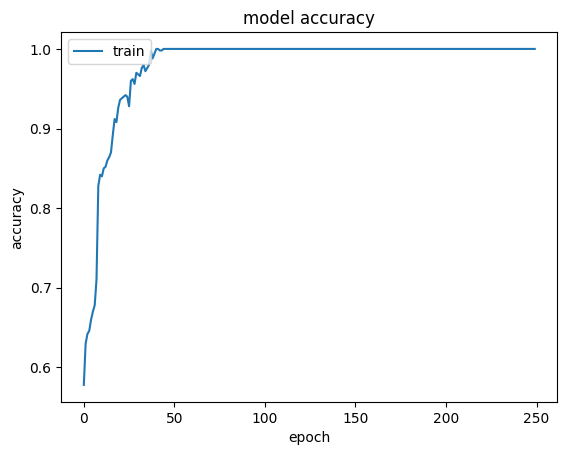

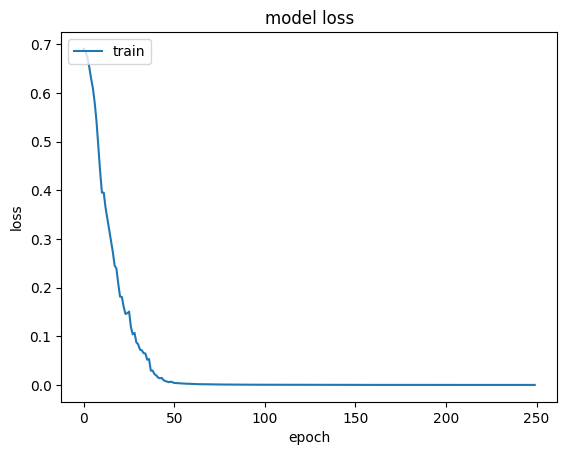

In [31]:
#PLOTAR A CURVA DE ACCURACY:

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#PLOTAR A CURVA DE LOSS:

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
def predicao_Acertos(coordenadasTeste,labelsValidacao):     #Função que recebe um dataset de teste e retorna o percentual de acerto da rede
                                                            #ao categorizar os seus elementos

    count = 0                                               #variável que conta o número de acertos
    arrayComparacao = []                                    #lista de labels previstas pela mlp

    previsoes = modelo.predict(coordenadasTeste)            #realiza previsões para as coordenadas de teste

    for i in range(len(previsoes)):                         #preenche arrayComparacao (unidimensional) com essas previsões
        arrayComparacao.append(previsoes[i][0])

    arrayComparacao = np.round(arrayComparacao)             #arredondamento de valores ponto flutuante para inteiro (ex.: 0.99999 para 1)
    labelsValidacao = np.round(labelsValidacao)

    for i in range(len(arrayComparacao)):                   #compara as previsões da rede com os labels de teste
        if arrayComparacao[i] == labelsValidacao[i]:        #para cata acerto da rede, incrementa count
            count += 1
    print(f"A rede acertou {(count/len(arrayComparacao))*100}% das previsões")  #retorna a porcentagem de acertos da rede ao categorizar
                                                                                #as coordenadas de teste


#TESTE AS PREVISÕES DA REDE AQUI \/

predicao_Acertos(teste.coordenadas,teste.labels)

#TESTE AS PREVISÕES DA REDE AQUI /\

16/16 [==============================] - 0s 2ms/step
A rede acertou 94.8% das previsões
